## Gathr data from Yfinance

In [170]:
import yfinance as yf 

# get data for BTC-USD
ticker = yf.Ticker("BTC-USD")
data = ticker.history(period="2y", interval="1d")
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 731 entries, 2021-12-02 00:00:00+00:00 to 2023-12-02 00:00:00+00:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          731 non-null    float64
 1   High          731 non-null    float64
 2   Low           731 non-null    float64
 3   Close         731 non-null    float64
 4   Volume        731 non-null    int64  
 5   Dividends     731 non-null    int64  
 6   Stock Splits  731 non-null    int64  
dtypes: float64(4), int64(3)
memory usage: 45.7 KB


In [171]:
prediction_data = data.copy()
# drop columns not needed for prediction which are Volume	Dividends	Stock Splits
prediction_data.drop(['Volume', 'Dividends', 'Stock Splits'], axis=1, inplace=True)
# remove timezones from index
prediction_data.index = prediction_data.index.tz_localize(None)
prediction_data

,Open,High,Low,Close
Date,,,,
2021-12-02,57217.371094,57349.234375,55895.132812,56477.816406
2021-12-03,56509.164062,57482.167969,52496.585938,53598.246094
2021-12-04,53727.878906,53904.679688,42874.617188,49200.703125
2021-12-05,49201.519531,49768.148438,47857.496094,49368.847656
2021-12-06,49413.480469,50929.519531,47281.035156,50582.625000
...,...,...,...,...
2023-11-28,37247.992188,38368.480469,36891.089844,37831.085938
2023-11-29,37826.105469,38366.113281,37612.632812,37858.492188
2023-11-30,37861.117188,38141.753906,37531.140625,37712.746094


In [172]:
def get_data_for_prophet(data, col):
    new_data = data.copy()
    # reset the index
    new_data.reset_index(inplace=True)
    # create a new dataframe with only the columns 'Date' and 'col'
    new_data = new_data[['Date', col]]
    # rename the columns to fit prophet
    new_data.rename(columns={'Date':'ds', col:'y'}, inplace=True)
    return new_data

# get the data for the prophet model

pred_close = get_data_for_prophet(prediction_data, 'Close')
pred_open = get_data_for_prophet(prediction_data, 'Open')
pred_high = get_data_for_prophet(prediction_data, 'High')
pred_low = get_data_for_prophet(prediction_data, 'Low')


In [173]:
from prophet import Prophet

# create a function to predict the future with prophet
def predict_future(data, col):
    # create the model
    model = Prophet()
    # fit the model
    model.fit(data)
    # create future dates
    future = model.make_future_dataframe(periods=30)
    # predict the future
    forecast = model.predict(future)
    # keep on the following columns in this order ds yhat yhat_lower yhat_upper
    forecast = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
    # rename the columns to ds prediction lower upper
    forecast.rename(columns={'ds':'Date', 'yhat':f'prediction_{col}', 'yhat_lower':f'lower_{col}', 'yhat_upper':f'upper_{col}'}, inplace=True)
    # return the forecast
    return forecast

In [174]:
forecast_close = predict_future(pred_close, 'Close')
forecast_open = predict_future(pred_open, 'Open')
forecast_high = predict_future(pred_high, 'High')
forecast_low = predict_future(pred_low, 'Low')

00:52:20 - cmdstanpy - INFO - Chain [1] start processing
00:52:20 - cmdstanpy - INFO - Chain [1] done processing
00:52:21 - cmdstanpy - INFO - Chain [1] start processing
00:52:21 - cmdstanpy - INFO - Chain [1] done processing
00:52:22 - cmdstanpy - INFO - Chain [1] start processing
00:52:22 - cmdstanpy - INFO - Chain [1] done processing
00:52:22 - cmdstanpy - INFO - Chain [1] start processing
00:52:22 - cmdstanpy - INFO - Chain [1] done processing


In [175]:
forecast_close

,Date,prediction_Close,lower_Close,upper_Close
0,2021-12-02,50553.867333,48290.054929,52686.781712
1,2021-12-03,50318.684425,48017.549275,52498.431801
2,2021-12-04,50149.128883,47955.515183,52427.188893
3,2021-12-05,50014.577243,47835.735499,52122.104645
4,2021-12-06,49841.599352,47684.886489,51945.717113
...,...,...,...,...
756,2023-12-28,41090.602853,38682.317633,43216.875027
757,2023-12-29,41203.197215,38973.875977,43292.459913
758,2023-12-30,41388.732731,39127.668860,43678.120525
759,2023-12-31,41615.430581,39380.916843,43999.279830


In [176]:
# create a function to rename the columns from ds to Date and y to name passed as parameter
def rename_columns(data, name):
    data.rename(columns={'ds':'Date', 'y':name}, inplace=True)
    return data


In [177]:
pred_close = rename_columns(pred_close, 'Close')
pred_open = rename_columns(pred_open, 'Open')
pred_high = rename_columns(pred_high, 'High')
pred_low = rename_columns(pred_low, 'Low')

In [178]:
# create a function that will join the data frames together that are passed as parameters
def join_data(data1, data2, data3, data4):
    # Joining data2, data3, and data4 with data1 side by side
    # Assuming all dataframes have the same index
    new_data = data1.join(data2, lsuffix='_1', rsuffix='_2')
    new_data = new_data.join(data3, lsuffix='', rsuffix='_3')
    new_data = new_data.join(data4, lsuffix='', rsuffix='_4')
    return new_data


In [179]:
orig_ochl = join_data(pred_open, pred_close, pred_high, pred_low)
pred_ochl = join_data(forecast_open, forecast_close, forecast_high, forecast_low)


In [180]:
# drop the date colums that have a suffix of _2, _3, _4
orig_ochl.drop(['Date', 'Date_2', 'Date_4'], axis=1, inplace=True)
# rename Date_1 to Date
orig_ochl.rename(columns={'Date_1':'Date'}, inplace=True)
orig_ochl

,Date,Open,Close,High,Low
0,2021-12-02,57217.371094,56477.816406,57349.234375,55895.132812
1,2021-12-03,56509.164062,53598.246094,57482.167969,52496.585938
2,2021-12-04,53727.878906,49200.703125,53904.679688,42874.617188
3,2021-12-05,49201.519531,49368.847656,49768.148438,47857.496094
4,2021-12-06,49413.480469,50582.625000,50929.519531,47281.035156
...,...,...,...,...,...
726,2023-11-28,37247.992188,37831.085938,38368.480469,36891.089844
727,2023-11-29,37826.105469,37858.492188,38366.113281,37612.632812
728,2023-11-30,37861.117188,37712.746094,38141.753906,37531.140625
729,2023-12-01,37718.007812,38688.750000,38954.109375,37629.359375


In [181]:
# drop the date colums that have a suffix of _2, _3, _4
pred_ochl.drop(['Date', 'Date_2', 'Date_4'], axis=1, inplace=True)
# rename Date_1 to Date
pred_ochl.rename(columns={'Date_1':'Date'}, inplace=True)
pred_ochl

,Date,prediction_Open,lower_Open,upper_Open,prediction_Close,lower_Close,upper_Close,prediction_High,lower_High,upper_High,prediction_Low,lower_Low,upper_Low
0,2021-12-02,51539.081456,49489.703834,53684.378822,50553.867333,48290.054929,52686.781712,52908.132303,50748.973284,55267.510070,48630.362835,46118.582428,51127.647139
1,2021-12-03,51201.861348,49033.624725,53323.827101,50318.684425,48017.549275,52498.431801,52582.691251,50492.490434,54676.294604,48411.590662,45732.437601,51121.688159
2,2021-12-04,50933.744155,48728.212782,53154.079175,50149.128883,47955.515183,52427.188893,52046.157933,50025.494593,54291.275235,48452.633853,45775.529995,50989.010674
3,2021-12-05,50714.519124,48527.156806,53021.428557,50014.577243,47835.735499,52122.104645,51925.784900,49880.620836,54003.786303,48312.562970,45836.204398,50783.141513
4,2021-12-06,50555.574178,48411.585265,52739.188920,49841.599352,47684.886489,51945.717113,51919.030320,49760.483966,54062.902431,47870.471694,45474.343980,50346.435586
...,...,...,...,...,...,...,...,...,...,...,...,...,...
756,2023-12-28,40915.327725,38373.566771,43296.083264,41090.602853,38682.317633,43216.875027,41727.571538,39594.952200,44023.268896,38163.183640,35611.604405,40557.894675
757,2023-12-29,40972.636463,38704.457919,43460.233394,41203.197215,38973.875977,43292.459913,41823.942453,39504.145970,44135.800020,38204.123139,35694.979426,40653.560353
758,2023-12-30,41108.059611,38808.017593,43360.301894,41388.732731,39127.668860,43678.120525,41717.875847,39451.699291,44032.700548,38509.161354,36069.254636,40959.508935
759,2023-12-31,41300.177598,38837.593592,43557.136681,41615.430581,39380.916843,43999.279830,42035.592636,39792.439586,44496.975427,38635.779999,35941.555119,40979.302236


In [182]:
pred_ochl.columns

Index(['Date', 'prediction_Open', 'lower_Open', 'upper_Open',
       'prediction_Close', 'lower_Close', 'upper_Close', 'prediction_High',
       'lower_High', 'upper_High', 'prediction_Low', 'lower_Low', 'upper_Low'],
      dtype='object')

In [183]:
# create a dataframe from pred_ochl with only the columns Date, prediction_Open, prediction_Close, prediction_High, prediction_Low
pred_ochl_pred = pred_ochl[['Date', 'prediction_Open', 'prediction_Close', 'prediction_High', 'prediction_Low']]
# create a dataframe from pred_ochl with only the columns Date, lower_Open, lower_Close, lower_High, lower_Low, upper_Open, upper_Close, upper_High, upper_Low
pred_ochl_lower_upper = pred_ochl[['Date', 'lower_Open', 'lower_Close', 'lower_High', 'lower_Low', 'upper_Open', 'upper_Close', 'upper_High', 'upper_Low']]


In [184]:
pred_avg__lower_upper = pred_ochl_lower_upper.copy()

pred_avg__lower_upper['avg_Lower'] = pred_ochl_lower_upper[['lower_Open', 'lower_Close', 'lower_High', 'lower_Low']].mean(axis=1)
pred_avg__lower_upper['avg_Upper'] = pred_ochl_lower_upper[['upper_Open', 'upper_Close', 'upper_High', 'upper_Low']].mean(axis=1)
pred_avg__lower_upper = pred_avg__lower_upper[['Date', 'avg_Lower', 'avg_Upper']]
# set the index to Date
pred_avg__lower_upper.set_index('Date', inplace=True)
pred_avg__lower_upper.head()

,avg_Lower,avg_Upper
Date,,
2021-12-02,48661.828619,53191.579436
2021-12-03,48319.025509,52905.060416
2021-12-04,48121.188138,52715.388494
2021-12-05,48019.929385,52482.615254
2021-12-06,47832.824925,52273.561013


In [185]:
avg_lower = pred_avg__lower_upper[['avg_Lower']]
# rename column to Close
avg_lower.rename(columns={'avg_Lower':'Close'}, inplace=True) 
avg_upper = pred_avg__lower_upper[['avg_Upper']]
# rename column to Close
avg_upper.rename(columns={'avg_Upper':'Close'}, inplace=True)

avg_lower.info()
avg_upper.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 761 entries, 2021-12-02 to 2024-01-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   761 non-null    float64
dtypes: float64(1)
memory usage: 11.9 KB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 761 entries, 2021-12-02 to 2024-01-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   761 non-null    float64
dtypes: float64(1)
memory usage: 11.9 KB


C:\Users\sean7\AppData\Local\Temp\ipykernel_4632\3251912639.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  avg_lower.rename(columns={'avg_Lower':'Close'}, inplace=True)
C:\Users\sean7\AppData\Local\Temp\ipykernel_4632\3251912639.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  avg_upper.rename(columns={'avg_Upper':'Close'}, inplace=True)


In [186]:
# use mpl fincacne to plot the candlestick chart
import mplfinance as mpf

# create a function to plot the candlestick chart
def plot_candlestick(plot_original, plot_prediction, pred_avg__lower_upper, title):
    
    # Create a custom style
    s = mpf.make_mpf_style(rc={'axes.grid':False})

    # Initialize the figure with the custom style
    fig = mpf.figure(style=s ,figsize=(12,6))
    ax1 = fig.subplot()
    # Create a twin axis for the second plot
    ax2 = ax1.twinx()
    
    
    ap = mpf.make_addplot(pred_avg__lower_upper[['avg_Lower','avg_Upper']], ax=ax2, type='line', width=0.8, color='g')

    # Plot the original candlestick chart
    mpf.plot(plot_original ,ax=ax1, type='candle',style='default')
    
    # Plot the prediction candlestick chart
    mpf.plot(plot_prediction,ax=ax2, addplot=ap, type='candle',style='yahoo')

    # add title to the plot
    ax1.set_title(title)
    
    mpf.show()

In [187]:
forecasted_df = pred_ochl_pred.copy()
# rename the columns to Open, Close, High, Low
forecasted_df.rename(columns={'prediction_Open':'Open', 'prediction_Close':'Close', 'prediction_High':'High', 'prediction_Low':'Low'}, inplace=True)
forecasted_df.head()


,Date,Open,Close,High,Low
0,2021-12-02,51539.081456,50553.867333,52908.132303,48630.362835
1,2021-12-03,51201.861348,50318.684425,52582.691251,48411.590662
2,2021-12-04,50933.744155,50149.128883,52046.157933,48452.633853
3,2021-12-05,50714.519124,50014.577243,51925.784900,48312.562970
4,2021-12-06,50555.574178,49841.599352,51919.030320,47870.471694


In [188]:
plot_original = orig_ochl.copy()
plot_original.set_index('Date', inplace=True)
plot_prediction = pred_ochl_pred.copy()
# rename the columns to Open, Close, High, Low
plot_prediction.rename(columns={'prediction_Open':'Open', 'prediction_Close':'Close', 'prediction_High':'High', 'prediction_Low':'Low'}, inplace=True)
plot_prediction.set_index('Date', inplace=True)

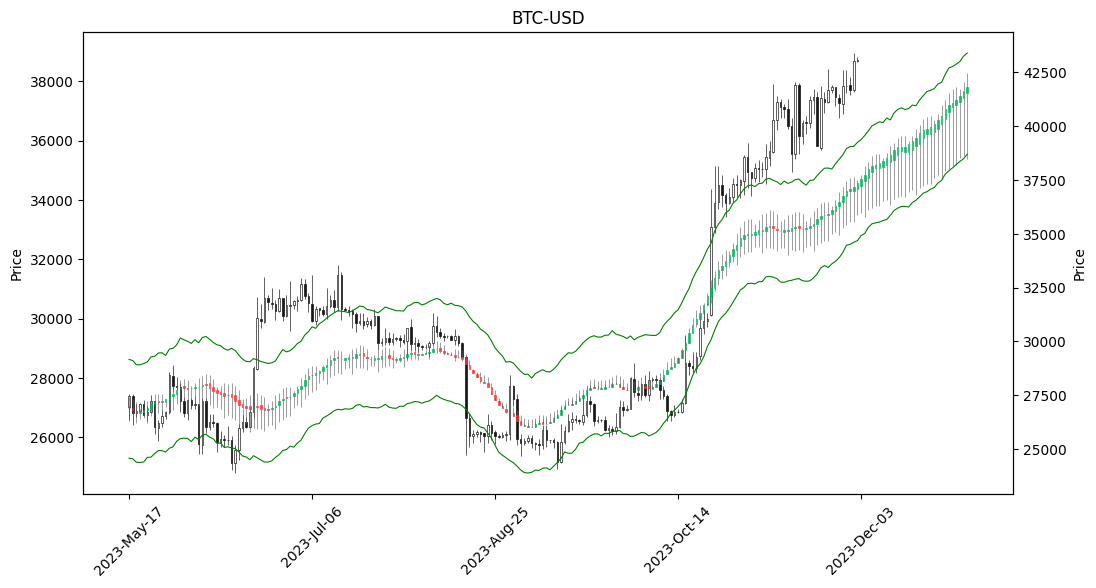

In [189]:
plot_candlestick(plot_original.tail(200), plot_prediction.tail(230), pred_avg__lower_upper.tail(230), 'BTC-USD')